In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

In [ ]:
path ='/content/drive/MyDrive/project/data/'

In [ ]:
os.chdir(path)

In [ ]:
df = pd.read_csv('hankyung_news_stock.csv')
df

,index,Close,Open,High,Low,Volume,Change,title,en_list
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,Blood-defense vigilant is a gold refinery indu...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,Automotive Daily Auto CHECK DAILY AUTO CHECK D...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,Distribution Daily Comments and News Updates D...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,Tesla Semiconductor IT Softer Market Ahead Sem...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,Distribution Amazon 3q18 Review Right Coexist ...
...,...,...,...,...,...,...,...,...,...
732,2021-10-15,3015.06,3012.62,3021.90,2999.33,857800000.0,0.0088,오락 디즈니플러스 쇼케이스 요약 쇼케이스 내내 콘텐츠 강조화학 신사업 ...,Entertainment Disney Plus Showcase Summary Cor...
733,2021-10-18,3006.68,3017.48,3021.17,2990.44,926370000.0,-0.0028,제약 제약 바이오 Weekly 제약 바이오 주간 코멘트국내 주요 뉴스 및 공시...,Pharmaceutical Bio Weekly Major News & Public ...
734,2021-10-19,3029.04,3022.23,3034.53,3014.19,845700000.0,0.0074,방송 비디어 중국 규제 피해는 정말 없는 것 같습니다 중국 규제 피해는 정말 없는...,Broadcasting Videos China Regulatory Damage se...
735,2021-10-20,3013.13,3043.13,3047.24,3012.97,668300.0,-0.0053,조선 meritz 조선 기계 Daily 국내외 주요 뉴스 및 코멘트자동차 ...,Joseon Meritz Joseon Machinery Daily Daily Maj...


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
for i in range(len(df)):
    df.en_list[i] = ' '.join(text_to_word_sequence(df.en_list[i]))

In [ ]:
df.head()

,index,Close,Open,High,Low,Volume,Change,title,en_list
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,blood defense vigilant is a gold refinery indu...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,automotive daily auto check daily auto check d...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,distribution daily comments and news updates d...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,tesla semiconductor it softer market ahead sem...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,distribution amazon 3q18 review right coexist ...


## 불용어 제거

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
len(stopwords.words('english'))

179

In [ ]:
from nltk.tokenize import word_tokenize  
stop_words = set(stopwords.words('english')) 

title_str = []
for i in range(len(df)):
    word_tokens = word_tokenize(df.en_list[i].lower())
    result = ' '.join([w for w in word_tokens if w not in stop_words])
    title_str.append(result)

In [ ]:
df['title_cln'] = title_str
df.head()

,index,Close,Open,High,Low,Volume,Change,title,en_list,title_cln
0,2018-10-22,2161.71,2143.08,2163.21,2136.92,308740000.0,0.0025,방산 방심은 금물 방산 방심은 금물정유 화학업종 IMO 2020 카슈끄지 그리...,blood defense vigilant is a gold refinery indu...,blood defense vigilant gold refinery industry ...
1,2018-10-23,2106.10,2147.30,2148.80,2094.69,373470000.0,-0.0257,자동차 Daily Auto Check 자동차 Daily Auto Check유통 D...,automotive daily auto check daily auto check d...,automotive daily auto check daily auto check d...
2,2018-10-24,2097.58,2119.19,2121.36,2092.10,399730000.0,-0.0040,유통 Daily 코멘트 및 뉴스 업데이트 Daily 코멘트 및 뉴스 업데이트디스플...,distribution daily comments and news updates d...,distribution daily comments news updates daily...
3,2018-10-25,2063.30,2046.67,2066.06,2033.81,376010000.0,-0.0163,건설업종 투자의 시대 투자의 시대자동차 흑자전환에 성공한 Tesla 흑자전환에 ...,tesla semiconductor it softer market ahead sem...,tesla semiconductor softer market ahead semico...
4,2018-10-26,2027.15,2066.57,2066.57,2008.86,449200000.0,-0.0175,유통 Amazon 3Q18 Review 희비 공존 Amazon 3Q18 Revi...,distribution amazon 3q18 review right coexist ...,distribution amazon 3q18 review right coexist ...


In [ ]:
fre_word = [t for tr in df for t in df.title_cln] 

In [ ]:
s_fre_word = str(fre_word)

In [ ]:
s_fre_list = s_fre_word.split()

In [ ]:
len(s_fre_list)

2284630

In [ ]:
np.unique(s_fre_list)

array(['"2019', '"5', '"5g', ..., '키', '특히', '합'], dtype='<U108')

In [ ]:
len(np.unique(s_fre_list))

13067

In [ ]:
txt = nltk.Text(s_fre_list, name='word') # 빈도수 계산
print(txt)

<Text: word>


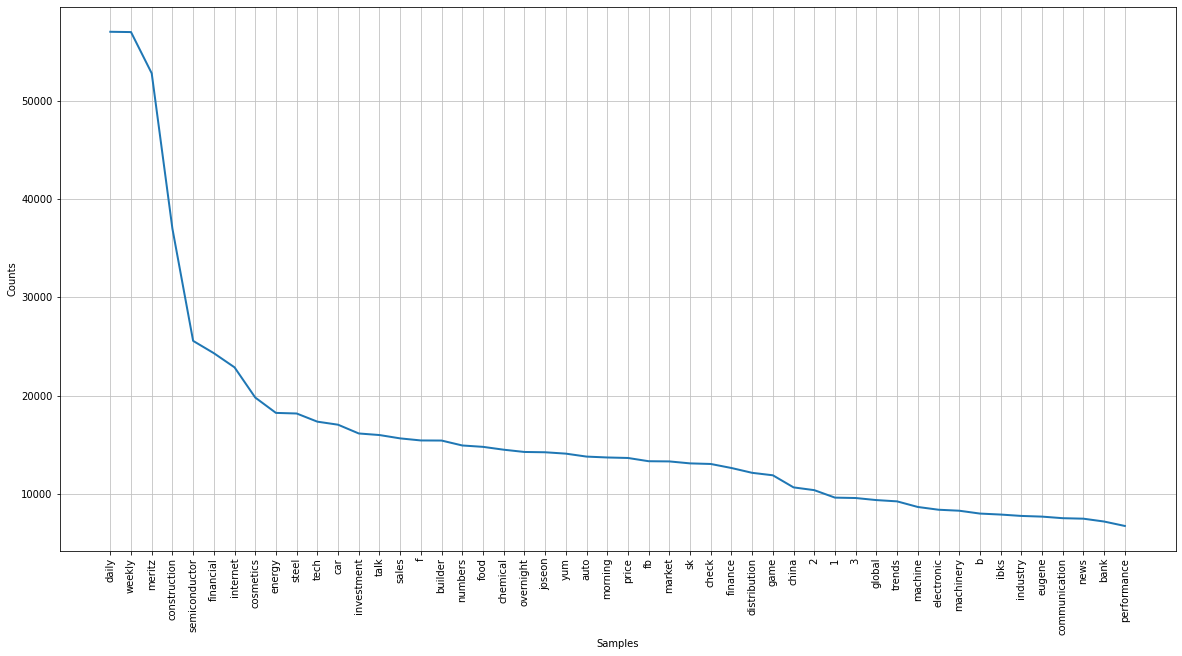

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
txt.plot(50)

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white',
               max_words=1000)
wc.generate_from_frequencies(dict(data))

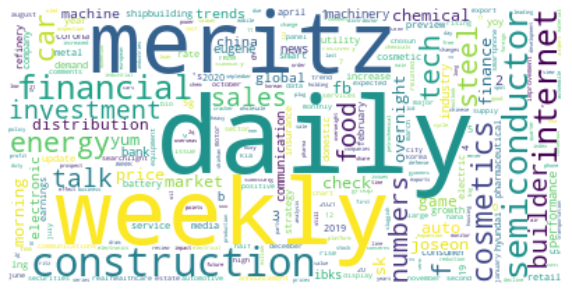

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear') # interpolation : 보간법
plt.axis('off')
plt.show()

In [ ]:
sel_token=[f[0] for f in txt.vocab().most_common(500)]
print(sel_token[:10])

['daily', 'weekly', 'meritz', 'construction', 'semiconductor', 'financial', 'internet', 'cosmetics', 'energy', 'steel']


In [ ]:
def frev(doc):
    return [doc.count(stoken) for stoken in sel_token]

## 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.title_cln, df.Change, test_size=0.1, random_state=0)

In [ ]:
train_x = [frev(d) for d in X_train] 
train_y = [d for d in y_train]

test_x = [frev(d) for d in X_test]
test_y = [d for d in y_test]

In [ ]:
train_x=np.asarray(train_x).astype('float32')
train_y=np.asarray(train_y).astype('float32')
test_x=np.asarray(test_x).astype('float32')
test_y=np.asarray(test_y).astype('float32')

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((663, 500), (663,), (74, 500), (74,))

## 모델 학습

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
np.random.seed(0)
model=models.Sequential()

model.add(layers.Dense(256, activation='relu',input_shape=(500,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

hist = model.fit(train_x,train_y,epochs=300,batch_size=200, validation_data=(test_x, test_y), verbose = 2, callbacks=[checkpoint, earlystopping])

Epoch 1/300
4/4 - 1s - loss: 0.6409 - mse: 1.9447 - val_loss: 0.3298 - val_mse: 0.7437

Epoch 00001: val_loss improved from inf to 0.32981, saving model to tmp/ckeckpointer.ckpt
Epoch 2/300
4/4 - 0s - loss: 0.1490 - mse: 0.3202 - val_loss: 0.0653 - val_mse: 0.1310

Epoch 00002: val_loss improved from 0.32981 to 0.06535, saving model to tmp/ckeckpointer.ckpt
Epoch 3/300
4/4 - 0s - loss: 0.0626 - mse: 0.1254 - val_loss: 0.0232 - val_mse: 0.0463

Epoch 00003: val_loss improved from 0.06535 to 0.02317, saving model to tmp/ckeckpointer.ckpt
Epoch 4/300
4/4 - 0s - loss: 0.0489 - mse: 0.0979 - val_loss: 0.0217 - val_mse: 0.0433

Epoch 00004: val_loss improved from 0.02317 to 0.02166, saving model to tmp/ckeckpointer.ckpt
Epoch 5/300
4/4 - 0s - loss: 0.0350 - mse: 0.0700 - val_loss: 0.0237 - val_mse: 0.0473

Epoch 00005: val_loss did not improve from 0.02166
Epoch 6/300
4/4 - 0s - loss: 0.0357 - mse: 0.0716 - val_loss: 0.0243 - val_mse: 0.0486

Epoch 00006: val_loss did not improve from 0.0216

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               128256    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

In [ ]:
pred = model.predict(test_x)

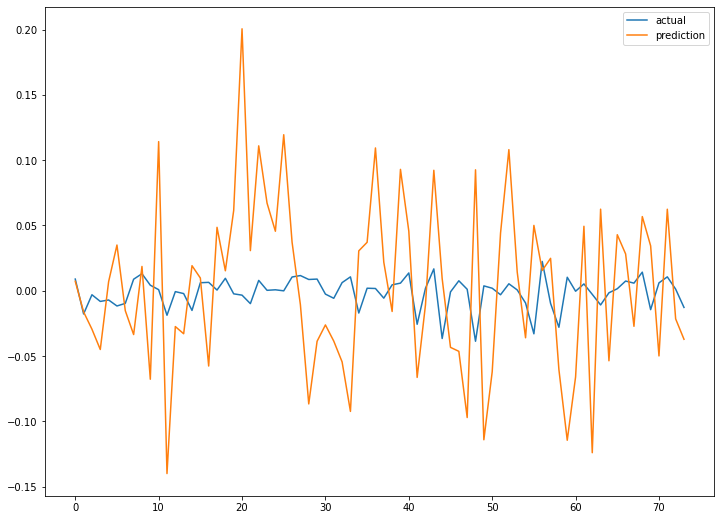

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend() 
plt.show() 

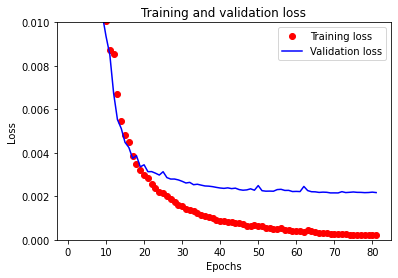

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,0.01))
plt.legend() 

plt.show()

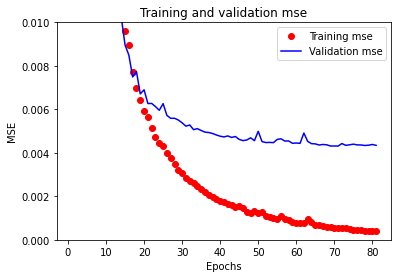

In [ ]:
mse = hist.history['mse']
val_mse = hist.history['val_mse']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'ro', label='Training mse')

plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE') 
plt.ylim((0,0.01))
plt.legend()

plt.show() 